In [4]:
# Import libraries
import pandas as pd
import re
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
#from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

# Import Data & Explore

In [142]:
# Import data
# link: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp?select=train.txt
train_file = 'train.txt'
val_file = 'val.txt'
test_file = 'test.txt'

train_df = pd.read_csv(train_file, sep=';')
val_df = pd.read_csv(val_file, sep=';')
test_df = pd.read_csv(test_file, sep=';')

train_df.columns = ['text', 'emotion']
val_df.columns = ['text', 'emotion']
test_df.columns = ['text', 'emotion']

print("Train Label Counts")
print(train_df.emotion.value_counts())
print(f"Train total: {len(train_df)}")

print("\nValidation Label Counts")
print(val_df.emotion.value_counts())
print(f"Validation total: {len(val_df)}")

print("\nTest Label Counts")
print(test_df.emotion.value_counts())
print(f"Test total: {len(test_df)}")

# View head
train_df.head()

Train Label Counts
joy         5362
sadness     4665
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64
Train total: 15999

Validation Label Counts
joy         704
sadness     549
anger       275
fear        212
love        178
surprise     81
Name: emotion, dtype: int64
Validation total: 1999

Test Label Counts
joy         695
sadness     580
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64
Test total: 1999


,text,emotion
0,i can go from feeling so hopeless to so damned...,sadness
1,im grabbing a minute to post i feel greedy wrong,anger
2,i am ever feeling nostalgic about the fireplac...,love
3,i am feeling grouchy,anger
4,ive been feeling a little burdened lately wasn...,sadness


In [7]:
# Check totals per label
emo_grouped_train = train_df.groupby(by=['emotion']).count().reset_index()
emo_grouped_val = val_df.groupby(by=['emotion']).count().reset_index()
emo_grouped_test = test_df.groupby(by=['emotion']).count().reset_index()

<AxesSubplot:xlabel='emotion', ylabel='text'>

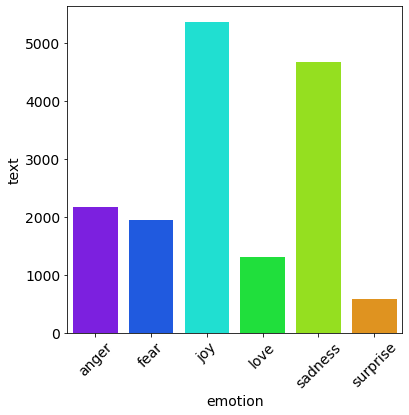

In [8]:
# Plot training emotion counts
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=45)

sns.barplot(x='emotion', y='text', data=emo_grouped_train, palette='gist_rainbow_r')

<AxesSubplot:xlabel='emotion', ylabel='text'>

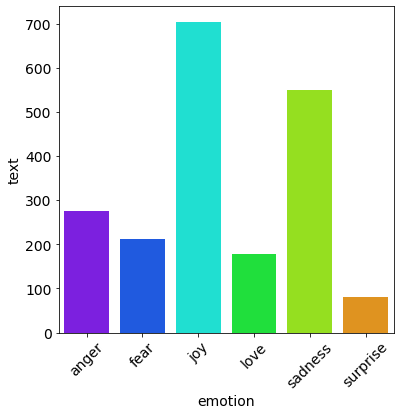

In [9]:
# Plot validation emotion counts
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=45)

sns.barplot(x='emotion', y='text', data=emo_grouped_val, palette='gist_rainbow_r')

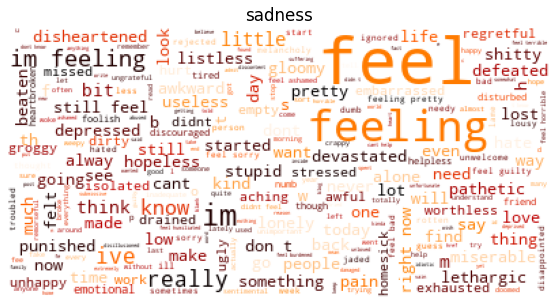

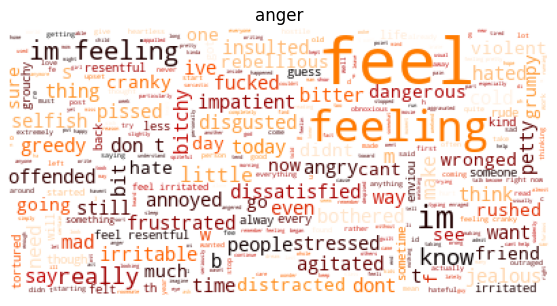

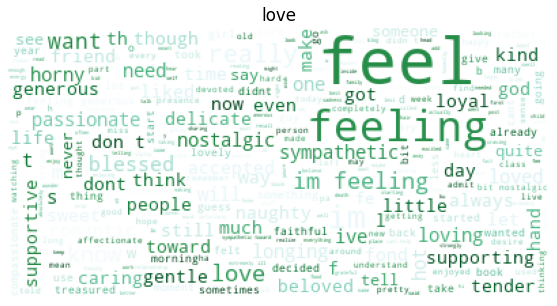

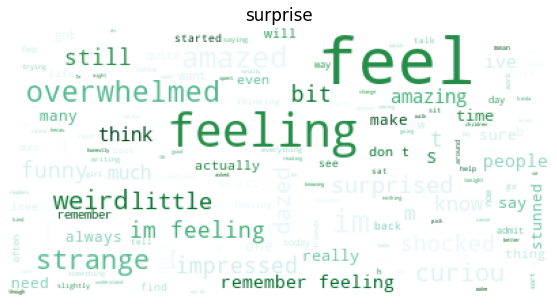

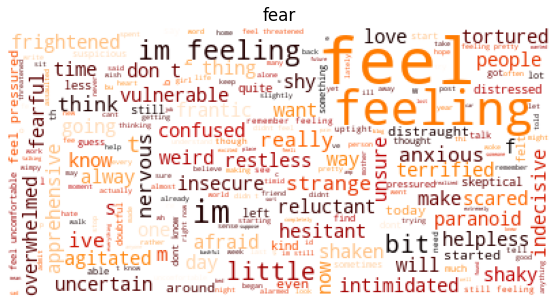

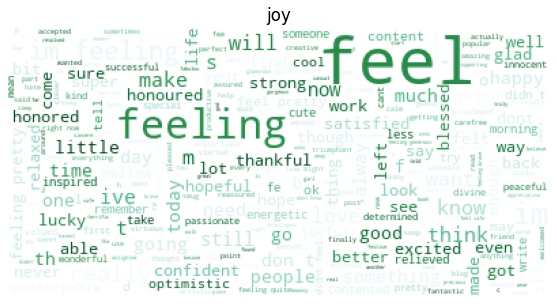

In [10]:
# Wordclouds
wc_stopwords=set(STOPWORDS)
plt.rcParams["figure.figsize"] = (14,5)

# Color text by positive vs negative emotion
positive_emotions = ['love', 'surprise', 'joy']
negative_emotions = ['sadness', 'anger', 'fear']

for x in train_df['emotion'].unique():
    if x in positive_emotions:
        color = 'BuGn'
    elif x in negative_emotions:
        color='gist_heat'
            
    wc = WordCloud(background_color='white', max_words=2000, stopwords=wc_stopwords, max_font_size=48, random_state=42,
                  colormap=color)
    wc.generate(train_df['text'][train_df['emotion'] == x].to_string())
    plt.imshow(wc)
    plt.title(x)
    plt.axis('off')
    plt.show()  

# Data Label Check

A previous emotion classification dataset was used for this project, using sentiment analysis I found that many samples for each emotion did not match the expected sentiment score. For example, many samples labeled 'love' had negative sentiment. Running the check here to validate the labels are good for this data set. In this section I will check the label quality by comparing sentiment score against postive vs negative emotions.

In [11]:
# Compare emotion against VADER sentiment score
sid = SentimentIntensityAnalyzer()

def vader_sentiment(x):
    ss = sid.polarity_scores(x)
    compound = ss['compound']  # Return the compound/agggreated score (ss also has neg, neu, & pos)
    return compound

check_sent = train_df.copy()
check_sent['VADER_Sentiment'] = train_df.apply(lambda x: vader_sentiment(x['text']), axis=1)
check_sent.head()

,text,emotion,VADER_Sentiment
0,i can go from feeling so hopeless to so damned...,sadness,0.0821
1,im grabbing a minute to post i feel greedy wrong,anger,-0.6597
2,i am ever feeling nostalgic about the fireplac...,love,0.1280
3,i am feeling grouchy,anger,-0.3400
4,ive been feeling a little burdened lately wasn...,sadness,-0.4346


<AxesSubplot:xlabel='emotion', ylabel='VADER_Sentiment'>

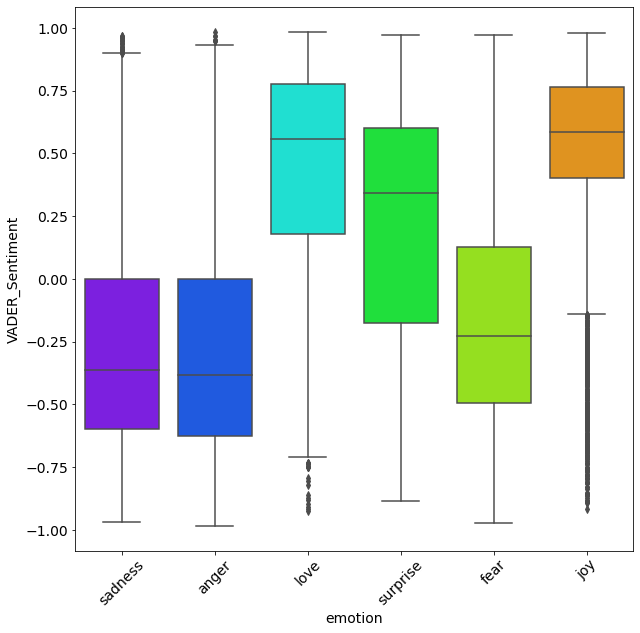

In [12]:
# Xoxplot of compound score by each emotion, check to see if anything looks off
plt.rcParams["figure.figsize"] = (10,10)
plt.xticks(rotation=45)
sns.boxplot(x='emotion', y='VADER_Sentiment', data=check_sent, palette='gist_rainbow_r')

Sadness, anger, and fear have lower sentiment scores than the positive emotions of joy, surprise, and love. Will check a few of the mismatching sentiment scores vs emotion type (positive vs negative) and validate the labels are good quality.

In [13]:
# Create indicator if emotion does not match sentiment score. Ex: anger has a compound sentiment score of .75.
positive_emotions = ['love', 'surprise', 'joy']
negative_emotions = ['sadness', 'anger', 'fear']

def find_conflicts(x, y):
    if x in positive_emotions and y <= -0.5:
        return 1
    elif x in negative_emotions and y >= 0.5:
        return 1
    else:
        return 0
    
check_sent['Mismatched_Sent_Ind'] = check_sent.apply(lambda x: find_conflicts(x['emotion'], x['VADER_Sentiment']), axis=1)  

In [14]:
check_labels = check_sent[check_sent['Mismatched_Sent_Ind'] == 1]
check_labels.to_excel('check_emotion_labels.xlsx')
len(check_labels) # labels look good from quick glance

983

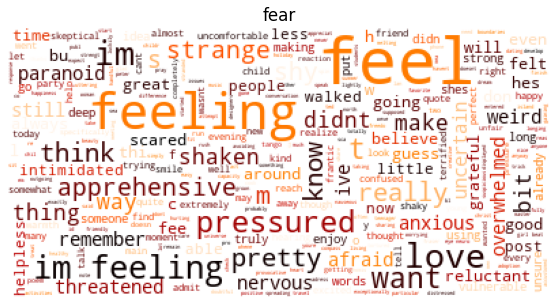

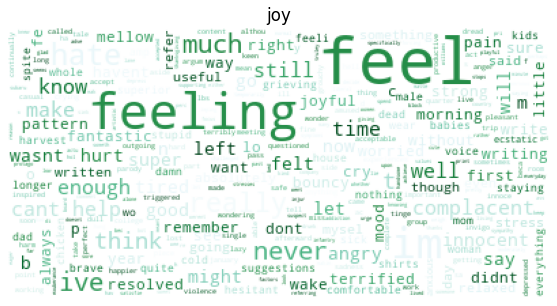

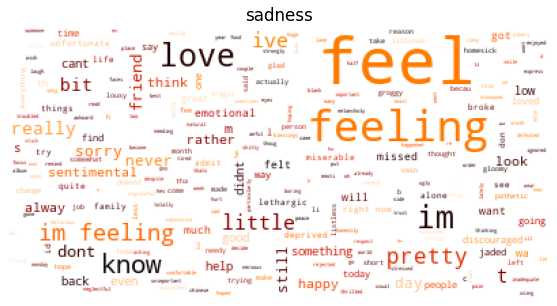

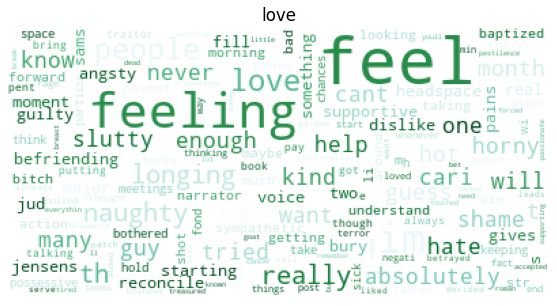

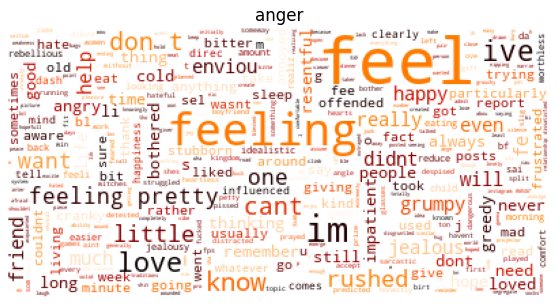

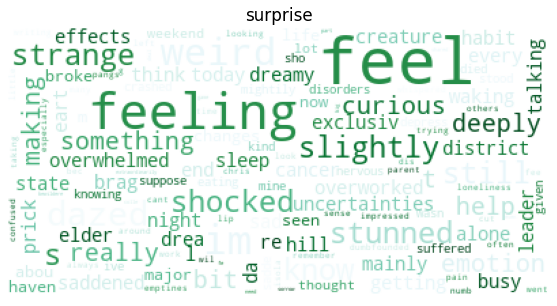

In [15]:
# Wordclouds to display the labels checked to validate they look good from a high-level
wc_stopwords=set(STOPWORDS)
plt.rcParams["figure.figsize"] = (14,5)

for x in check_labels['emotion'].unique():
    if x in positive_emotions:
        color = 'BuGn'
    elif x in negative_emotions:
        color='gist_heat'
            
    wc = WordCloud(background_color='white', max_words=2000, stopwords=wc_stopwords, max_font_size=48, random_state=42,
                  colormap=color)
    wc.generate(check_labels['text'][check_labels['emotion'] == x].to_string())
    plt.imshow(wc)
    plt.title(x)
    plt.axis('off')
    plt.show()    

The exmaples pulled looked correctly labeled. The words in the word cloud look good too. I did reuse the code for the wordclouds to generate wordclouds for the entire data set by label by changing the dataframe mentioned in the generate method call.

# Prep Data

In [79]:
# Update list of stopwords to remove common words
stop_words = list(set(stopwords.words("english")))
add_stopws = ['im', 'like', 'feel', 'get']
stop_words = stop_words + add_stopws

In [143]:
# Lemmatize
from nltk import word_tokenize

lemmer = WordNetLemmatizer()

def lemmatize(text):
    words = word_tokenize(text)
    lem_output = ' '.join([lemmer.lemmatize(w, pos='v') for w in words])
    return lem_output


train_df['text'] = train_df.apply(lambda x: lemmatize(x['text']), axis=1)
val_df['text'] = val_df.apply(lambda x: lemmatize(x['text']), axis=1)
test_df['text'] = test_df.apply(lambda x: lemmatize(x['text']), axis=1)

In [144]:
# Split text and labels
y_train = train_df['emotion'].values
X_train = train_df['text'].values

y_val = val_df['emotion'].values
X_val = val_df['text'].values

y_test = test_df['emotion'].values
X_test = test_df['text'].values

In [75]:
keep = [ 'not', 'i', 'we', 'yours', 'her', 'him', 'his', 'her', 'me', "i'd", "i'm", 'my', 'like', 'our', 'yourself', 'you', 
        'ours']
new_stopws = [w for w in stop_words if w not in keep]
print(new_stopws)

['what', 'the', 'against', 'in', 'o', "needn't", 'other', 'does', 'over', 'than', 'were', 'all', 'did', 'is', 'about', 'these', "shan't", 'was', 'haven', 'didn', 'of', 'had', 'for', "you've", 'ain', 'those', "shouldn't", 'wasn', 'most', 'which', 'won', 'their', 'out', "mightn't", 'now', 'too', 'that', 'on', 'then', 'no', 'am', 'should', 'll', 'y', 'isn', 'herself', "aren't", "wouldn't", 'very', 'same', 'its', 'do', 'ourselves', 'been', 'having', 'where', 'with', 'how', 'just', "hadn't", 'your', 'to', "it's", 'being', 're', "hasn't", 'needn', 'yourselves', 'nor', 'they', 'them', 'be', 'doesn', 'as', 'at', 'wouldn', 'don', 'shan', 'will', 'who', 'any', 'whom', 'some', 'if', 'weren', 'before', "you'd", "don't", 've', 'up', 'during', 'more', 'from', "won't", 'hasn', "that'll", "doesn't", 'or', 'can', 'she', 'are', 'below', 'a', 'has', 'because', 'itself', 'above', 'once', 'off', 't', 'd', 'ma', 'between', 'few', 'shouldn', 'so', 'after', 'down', 'have', 'again', 'until', 'themselves', 'why

In [20]:
# Count with unigrams and bigrams
count_vec = CountVectorizer(encoding='latin-1', 
                                binary=False, 
                                lowercase=True,
                                min_df=2,
                                ngram_range=(1,2),
                                stop_words=stop_words)
# Fit & transform train
X_train_count_vecd = count_vec.fit_transform(X_train)
# Transform val & test
X_val_count_vecd = count_vec.transform(X_val)
X_test_count_vecd = count_vec.transform(X_test)
# View shape
print(X_train_count_vecd.shape, X_val_count_vecd.shape, X_test_count_vecd.shape)

(15999, 14951) (1999, 14951) (1999, 14951)


In [145]:
# TF-IDF with unigrams and bigrams
tf_vec = TfidfVectorizer(encoding='latin-1', 
                                binary=False, 
                                lowercase=True,
                                min_df=2,
                                ngram_range=(1,2),
                                stop_words=stop_words)
# Fit transform train
X_train_tfidf_vecd = tf_vec.fit_transform(X_train)
# Transform val & test
X_val_tfidf_vecd = tf_vec.transform(X_val)
X_test_tfidf_vecd = tf_vec.transform(X_test)
# View shape
print(X_train_tfidf_vecd.shape, X_val_tfidf_vecd.shape, X_test_tfidf_vecd.shape)

(15999, 14951) (1999, 14951) (1999, 14951)


# Multinomial Naive Bayes

In [102]:
# MNB model
mnb = MultinomialNB()
mnb.fit(X_train_count_vecd, y_train)

# Test with validation
mnb_pred = mnb.predict(X_val_count_vecd)

#Accuracy, Precision, & Recall
print(classification_report(y_val, mnb_pred))

              precision    recall  f1-score   support

       anger       0.90      0.72      0.80       275
        fear       0.82      0.70      0.75       212
         joy       0.79      0.94      0.86       704
        love       0.90      0.40      0.55       178
     sadness       0.76      0.91      0.83       549
    surprise       0.88      0.17      0.29        81

    accuracy                           0.80      1999
   macro avg       0.84      0.64      0.68      1999
weighted avg       0.81      0.80      0.78      1999



Love and surprise had the lowest scores, they also had the lowest number of examples.

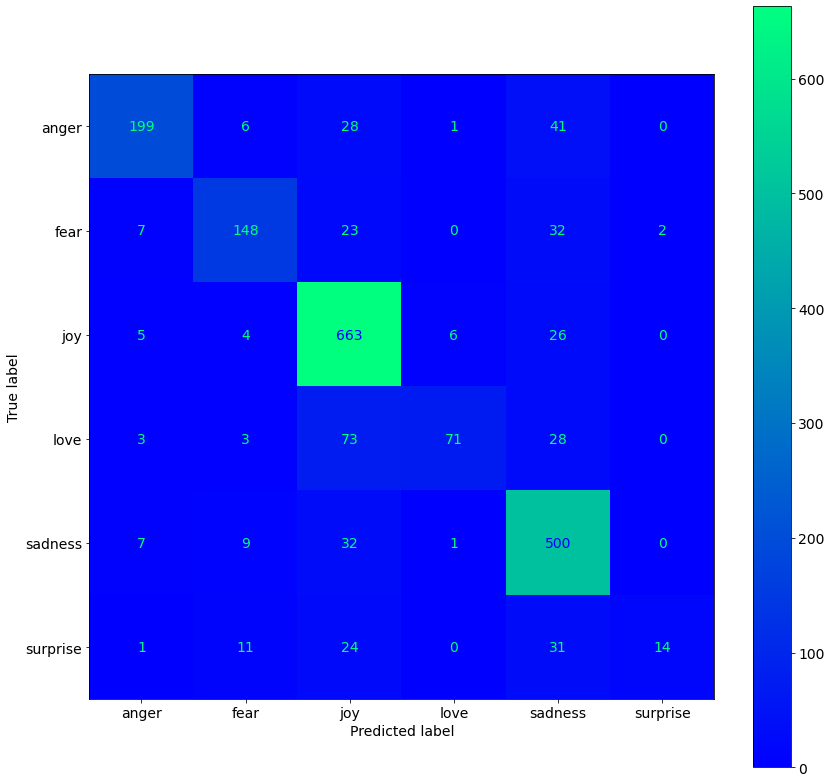

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_val, mnb_pred, labels = mnb.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = mnb.classes_)
fig, ax = plt.subplots(figsize=(14,14))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
cm_display.plot(cmap='winter', ax=ax)

Anger was confused for joy and sadness. 
Fear for joy and sadness. 
Joy was confused for sadness.
Love was incorrectly labeled as joy or sadness. 
Sadness was confused for joy.
Surpise was confused for fear, joy, and sadness.

Some emotions are similar to each other, like anger and sadness or surprise and fear. Sadness and joy were confused and those emotions are not very similar. 
Joy and sadness had higher training examples, could try to create equal number of examples from each emotion and test again.

In [25]:
# View the top ten indicative words for labels 0-5 (anger, fear, joy, love, sadness, and surprise)
feature_ranks = sorted(zip(mnb.feature_log_prob_[0], count_vec.get_feature_names()))
list_features = feature_ranks[-10:]
print("")
for score, word in list_features:
    print("{} : {}".format(word, score) )


little : -5.78678162052847
people : -5.78678162052847
say : -5.74974034884812
really : -5.621906977338235
want : -5.552380914689626
think : -5.544945936202107
go : -5.515746781509845
know : -5.515746781509845
time : -5.501460824262368
make : -5.446274408695078


### MNB with Balanced Labels 

In [26]:
# Split up training dataframe to include equal number of samples from each emotion
#new_train_df = check_sent[check_sent['Mismatched_Sent_Ind']==0]  # Try with matching sentiment scores, bad result (67% acc)
new_train_group = train_df.groupby('emotion')
new_train_df = new_train_group.apply(lambda x: x.sample(new_train_group.size().min()).reset_index(drop=True))

print("New Train Label Counts")
print(new_train_df.emotion.value_counts())
print(f"Train total: {len(new_train_df)}")

New Train Label Counts
anger       572
fear        572
joy         572
love        572
sadness     572
surprise    572
Name: emotion, dtype: int64
Train total: 3432


In [27]:
# Prepare data
# Lematize
new_train_df['text'] = new_train_df.apply(lambda x: lemmatize(x['text']), axis=1)

# Split text and labels
new_y_train = new_train_df['emotion'].values
new_X_train = new_train_df['text'].values

# Vectorize
# Fit & transform train
new_X_train_count_vecd = count_vec.fit_transform(new_X_train)
# Transform val & test
new_X_val_count_vecd = count_vec.transform(X_val)
new_X_test_count_vecd = count_vec.transform(X_test)
# View shape
print(new_X_train_count_vecd.shape, new_X_val_count_vecd.shape, new_X_test_count_vecd.shape)

(3432, 3550) (1999, 3550) (1999, 3550)


In [28]:
# MNB model
mnb2 = MultinomialNB()
mnb2.fit(new_X_train_count_vecd, new_y_train)

# Test with validation
mnb_pred2 = mnb2.predict(new_X_val_count_vecd)

#Accuracy, Precision, & Recall
print(classification_report(y_val, mnb_pred2))

              precision    recall  f1-score   support

       anger       0.64      0.75      0.69       275
        fear       0.60      0.74      0.66       212
         joy       0.85      0.62      0.72       704
        love       0.52      0.76      0.62       178
     sadness       0.80      0.69      0.74       549
    surprise       0.40      0.85      0.54        81

    accuracy                           0.69      1999
   macro avg       0.63      0.73      0.66      1999
weighted avg       0.73      0.69      0.70      1999



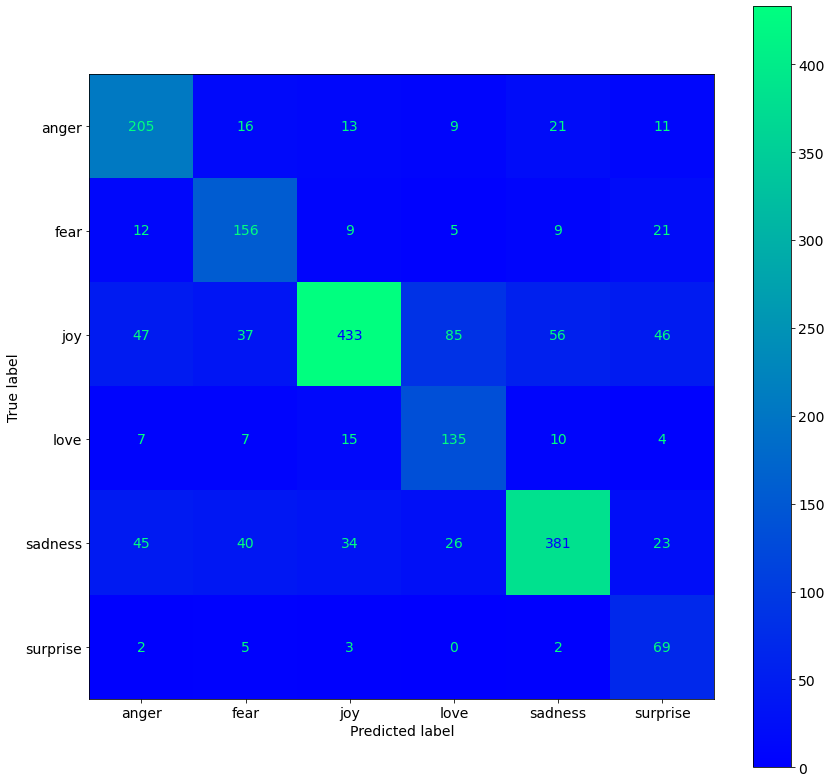

In [29]:
# Confusion matrix
cm = confusion_matrix(y_val, mnb_pred2, labels = mnb2.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = mnb2.classes_)
fig, ax = plt.subplots(figsize=(14,14))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
cm_display.plot(cmap='winter', ax=ax)

Sadness and joy performed worse than when they had higher number of examples.

# Support Vector Machine (Linear)

In [ ]:
# SVM - testing with different kernels and costs. Linear with cost = 1 produced best results.
from sklearn.svm import SVC
svm = SVC(C=1, kernel='linear') 

# Train with cross validation
svm_scores = cross_val_score(svm, X_train_tfidf_vecd, y_train, cv=5)
print(svm_scores)
print("avg: {}".format(sum(svm_scores/5)))

In [146]:
# Linear SVM without cross validation
#from sklearn.svm import LinearSVC
svm = LinearSVC(C=1)
svm.fit(X_train_tfidf_vecd, y_train)

# Test model
svm_pred = svm.predict(X_val_tfidf_vecd)

# View accuracy, Precision, & Recall
print(classification_report(y_val, svm_pred))

              precision    recall  f1-score   support

       anger       0.87      0.86      0.86       275
        fear       0.82      0.81      0.82       212
         joy       0.89      0.91      0.90       704
        love       0.82      0.71      0.76       178
     sadness       0.90      0.92      0.91       549
    surprise       0.80      0.78      0.79        81

    accuracy                           0.87      1999
   macro avg       0.85      0.83      0.84      1999
weighted avg       0.87      0.87      0.87      1999



In [159]:
# Linear SVM with testing set
# Test model
svm_pred_test = svm.predict(X_test_tfidf_vecd)

# View accuracy, Precision, & Recall
print(classification_report(y_test, svm_pred_test))

              precision    recall  f1-score   support

       anger       0.86      0.87      0.86       275
        fear       0.87      0.81      0.84       224
         joy       0.90      0.91      0.91       695
        love       0.76      0.73      0.74       159
     sadness       0.90      0.91      0.90       580
    surprise       0.67      0.67      0.67        66

    accuracy                           0.87      1999
   macro avg       0.82      0.82      0.82      1999
weighted avg       0.87      0.87      0.87      1999



In [147]:
# Pickle SVM
with open('emotion_clf_svm_v1.pkl', 'wb') as f:
    pickle.dump(svm, f)
    
# Read it back in
#with open('emotion_clf_svm_v1.pkl', 'rb') as f:
#    svm = pickle.load(f)

In [156]:
# Pickle tf-idf
with open('tfidf_vec.pkl', 'wb') as f:
    pickle.dump(tf_vec, f)
    
# Read it back in
#with open('tfidf_vec.pkl', 'rb') as f:
#    tf_vec = pickle.load(f)

Performed best with Linear SVM with a cost = 1. No lemmatizing, remove stopwords, use tf-idf

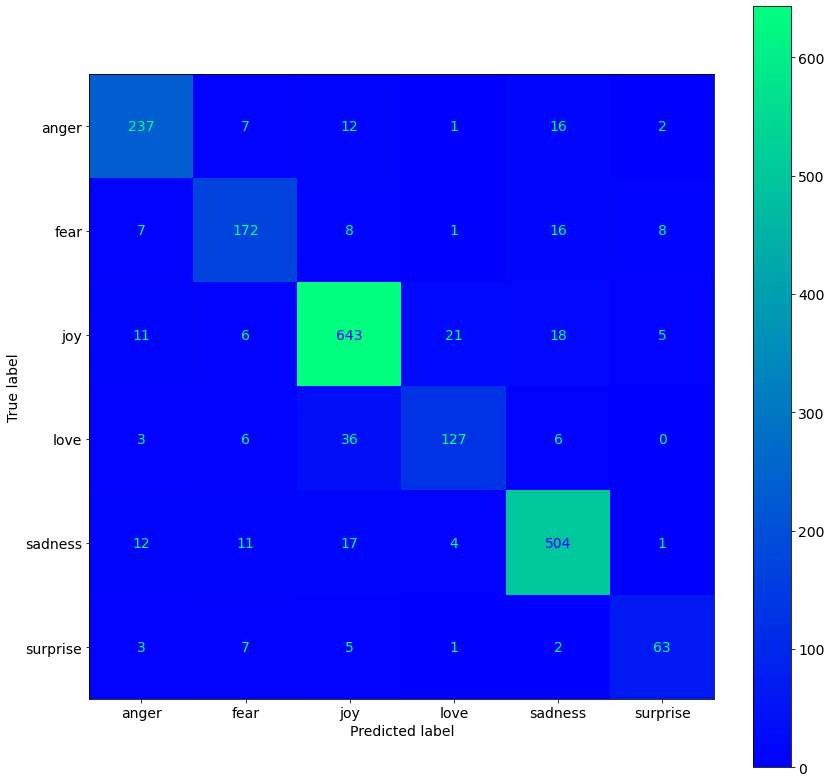

In [108]:
cm = confusion_matrix(y_val, svm_pred, labels = svm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = svm.classes_)
fig, ax = plt.subplots(figsize=(14,14))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
cm_display.plot(cmap='winter', ax=ax)

Better performance than MNB, similar emotions are still being confused with each other. Joy is being confused with sadness. Will check the text to find out why they are being classified in their neighboring emotion (anger & sadness, joy & love) rather than their own.

In [92]:
# View the top ten indicative words for labels 0-5 (anger, fear, joy, love, sadness, and surprise)
labels = ["anger", "fear", "joy", "love", "sadness", "surprise"]
for ind,lab in enumerate(labels):
    feature_ranks = sorted(zip(svm.coef_[ind], tf_vec.get_feature_names()))
    list_features = feature_ranks[-20:]
    print(f"\nTop 20 words for {lab}")
    for score, word in list_features:
        print("{} : {}".format(word, score) )


Top 20 words for anger
pissed : 3.5798652539781193
envious : 3.621546030727659
cranky : 3.6511042712016266
wronged : 3.715206535322767
selfish : 3.722048438011627
bitchy : 3.7539465171853887
violent : 3.7864834284714353
rebellious : 3.808354988403875
bothered : 3.8760290215818465
stubborn : 3.9209877791519667
dissatisfied : 3.936552240964585
rude : 3.957223877865149
petty : 3.9922335578041035
distracted : 4.091805621884863
fucked : 4.142940738577985
irritable : 4.150932464940255
greedy : 4.2824654422662
resentful : 4.289213774580116
dangerous : 4.447753942429974
offended : 4.53912822485922

Top 20 words for fear
suspicious : 3.5213684667331915
shy : 3.5971141970496845
distressed : 3.6505562049359903
skeptical : 3.6597331904094914
shaky : 3.665677582462049
fearful : 3.6707754999201128
unsure : 3.6799337191379617
hesitant : 3.7605083739128973
frightened : 4.021363903156478
frantic : 4.048290046891216
paranoid : 4.057307787488721
threatened : 4.094709366432153
vulnerable : 4.170739178149

In [157]:
# Test some predictions to see if the presence of the word 'feel' matter in the input. 
# All samples include "I feel..." or "I'm feeling..." and I wanted to see if they would match.
test_sents = ["I feel in awe watching the waves crash on the beach while the sun is setting", "the waves and sunset at the beach are awe inspiring"]
test_sents = ["I don't want to do homework", "I want to workout", "milk is disgusting"]
test_sents = [lemmatize(sent) for sent in test_sents]
#test_sents = [sent for sent in test_sents]
X_testsents_tfidf_vecd = tf_vec.transform(test_sents)
svm.predict(X_testsents_tfidf_vecd)

array(['sadness', 'joy', 'anger'], dtype=object)

### Check Incorrectly Labeled Examples for Improvement

In [34]:
# Create dataframe of incorrectly predicted samples
sents_wrong = []
act_lab = []
pred_lab = []
for i in range(len(svm_pred)):
    if svm_pred[i] != y_val[i]:
        act_lab.append(y_val[i])
        pred_lab.append(svm_pred[i])
        sents_wrong.append(val_df['text'].iloc[i])
        
print(len(act_lab), len(pred_lab), len(pred_lab))

wrong_preds = pd.DataFrame(list(zip(act_lab, pred_lab, sents_wrong)))
wrong_preds.columns = ['Actual', 'Predicted', 'Text']
wrong_preds.head()

253 253 253


,Actual,Predicted,Text
0,love,anger,i also love that you could really feel the des...
1,joy,love,i feel as if i be the beloved prepare herself ...
2,sadness,love,i would feel i miss out on a wealth of treasur...
3,sadness,anger,i only feel such an ache rush if im hear it
4,sadness,joy,i cant sleep i switch on music if i need to wa...


In [ ]:
wrong_preds.to_excel('Wrongly_Predicted.xlsx')

Will test out embeddings next to see if the results can be improved.

# SVM with GloVE

To download pre-trained vectors: https://nlp.stanford.edu/projects/glove/
This project uses the 6B tokens pretrained model.
https://www.kaggle.com/code/arunava21/word2vec-and-random-forest-classification/notebook

In [42]:
# Use Gensim to convert glove to word2vec format. 
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.50d.txt", word2vec_output_file="gensim_glove_vectors.txt")

# Read in converted format
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
# Now ou can use word2vec commands with glove embeddings

In [72]:
# Create embedding vectors
train_text = [nltk.word_tokenize(sent) for sent in train_df['text']]
train_text = [word for word in train_text if word not in stop_words]
glove_train_vecs = [[glove_model[word] for word in sent if word in glove_model.index_to_key] for sent in train_text[:1000]]
print(glove_train_vecs)

val_text = [nltk.word_tokenize(sent) for sent in val_df['text']]
val_text = [word for word in val_text if word not in stop_words]
#glove_val_vecs = [glove_model[word] for word in val_text if word in glove_model.index_to_key]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Not able to utilize glove embeddings on current machine.

In [57]:
# Pickle embeddings

# Save glove_train_vecs
with open('glove_train_vecs.pkl', 'wb') as f:
    pickle.dump(glove_train_vecs, f)
    
# Read it back in
with open('glove_train_vecs.pkl', 'rb') as f:
    glove_train_vecs = pickle.load(f)

# Save glove_val_vecs
with open('glove_val_vecs.pkl', 'wb') as f:
    pickle.dump(glove_val_vecs, f)
    
# Read it back in
with open('glove_val_vecs.pkl', 'rb') as f:
    glove_val_vecs = pickle.load(f)
    
# Save glove_model
with open('glove_model.pkl', 'wb') as f:
    pickle.dump(glove_model, f)
    
# Read it back in
with open('glove_model.pkl', 'rb') as f:
    glove_model = pickle.load(f)

In [65]:
# SVM with GloVE
svm_glove = LinearSVC(C=1)
svm_glove.fit(glove_train_vecs, train_df['emotion'])

# Test model
svm_glove_pred = svm.predict(glove_val_vecs)

# View accuracy, Precision, & Recall
print(classification_report(val_df['emotion'], svm_glove_pred))

[]

# SVM with Universal Sentence Encoder

In [36]:
# Load pretrained USE model
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")  # For savemodel error, delete folder & try again

In [37]:
# Original dataframes were cleaned (lemmatized) in previous step, USE requires no pre-processing. Re-importing data.
raw_train_df = pd.read_csv(train_file, sep=';')
raw_val_df = pd.read_csv(val_file, sep=';')
raw_test_df = pd.read_csv(test_file, sep=';')

raw_train_df.columns = ['text', 'emotion']
raw_val_df.columns = ['text', 'emotion']
raw_test_df.columns = ['text', 'emotion']

txt_embeddings = embed(raw_train_df["text"])
txt_embeddings.shape

TensorShape([15999, 512])

In [40]:
# SVM with USE embeddings
svm_use = LinearSVC(C=1)
svm_use.fit(txt_embeddings, raw_train_df["emotion"])

# Test model
val_txt_embeddings = embed(raw_val_df["text"])
svm_use_pred = svm_use.predict(val_txt_embeddings)

# View accuracy, Precision, & Recall
print(classification_report(raw_val_df["emotion"], svm_use_pred))

              precision    recall  f1-score   support

       anger       0.62      0.55      0.58       275
        fear       0.56      0.56      0.56       212
         joy       0.68      0.77      0.72       704
        love       0.60      0.31      0.41       178
     sadness       0.65      0.74      0.69       549
    surprise       0.59      0.25      0.35        81

    accuracy                           0.65      1999
   macro avg       0.62      0.53      0.55      1999
weighted avg       0.64      0.65      0.63      1999



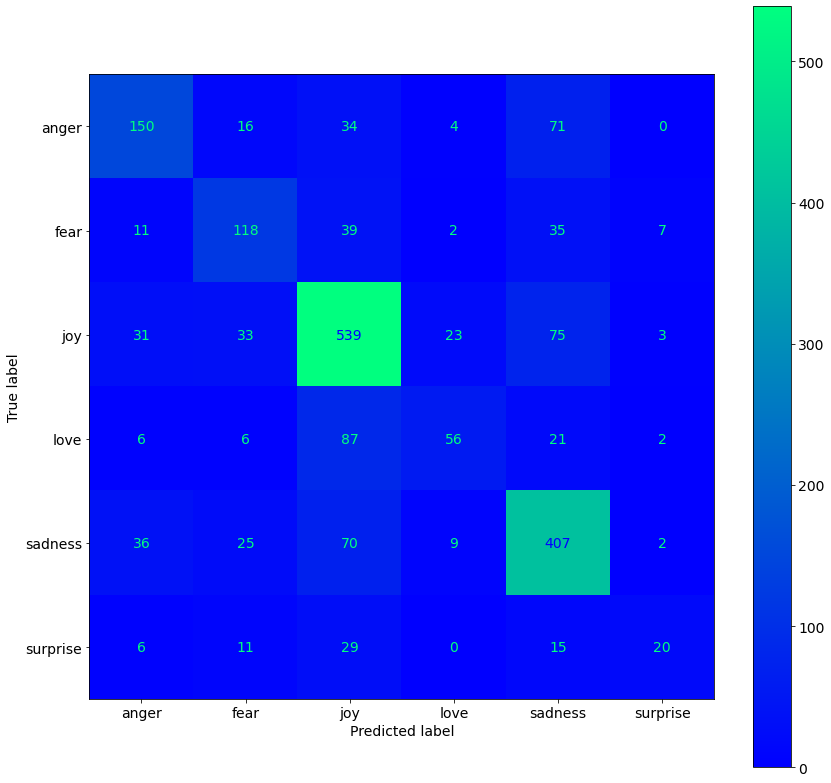

In [41]:
cm = confusion_matrix(raw_val_df["emotion"], svm_use_pred, labels = svm_use.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = svm_use.classes_)
fig, ax = plt.subplots(figsize=(14,14))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
cm_display.plot(cmap='winter', ax=ax)